## Install and Import Dependencies

In [1]:
# Installing Dependencies
# In my development environment, I use a virtual environment therefore I use % instead of !
# %pip install kagglehub
# %pip install pandas
# %pip install numpy
# %pip install matplotlib

%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing dependencies
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\chips\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [3]:
# Downloading the latest version of the dataset from Kaggle
# dataset_path = kagglehub.dataset_download("fedesoriano/stellar-classification-dataset-sdss17")
dataset_path = kagglehub.dataset_download("konivat/hipparcos-star-catalog")

print("Path to dataset files:", dataset_path)

Path to dataset files: C:\Users\chips\.cache\kagglehub\datasets\konivat\hipparcos-star-catalog\versions\1


In [4]:
# Loading the dataset into a pandas DataFrame
# df = pd.read_csv(os.path.join(dataset_path, "star_classification.csv"))
df_raw = pd.read_csv(os.path.join(dataset_path, "hipparcos-voidmain.csv"))

In [5]:
df_raw.head()

,Catalog,HIP,Proxy,RAhms,DEdms,Vmag,VarFlag,r_Vmag,RAdeg,DEdeg,...,Survey,Chart,Notes,HD,BD,CoD,CPD,(V-I)red,SpType,r_SpType
0,H,1,NaN,00 00 00.22,+01 05 20.4,9.10,NaN,H,0.000912,1.089013,...,S,NaN,NaN,224700.0,B+00 5077,NaN,NaN,0.66,F5,S
1,H,2,NaN,00 00 00.91,-19 29 55.8,9.27,NaN,G,0.003797,-19.498837,...,NaN,NaN,NaN,224690.0,B-20 6688,NaN,NaN,1.04,K3V,4
2,H,3,NaN,00 00 01.20,+38 51 33.4,6.61,NaN,G,0.005008,38.859286,...,S,NaN,NaN,224699.0,B+38 5108,NaN,NaN,0.00,B9,S
3,H,4,NaN,00 00 02.01,-51 53 36.8,8.06,NaN,H,0.008382,-51.893546,...,S,NaN,NaN,224707.0,NaN,NaN,P-52 12237,0.43,F0V,2
4,H,5,NaN,00 00 02.39,-40 35 28.4,8.55,NaN,H,0.009965,-40.591224,...,NaN,NaN,NaN,224705.0,NaN,C-41 15372,P-41 9991,0.95,G8III,2


#### Column meanings

0. Catalog ( Catalog_Name ) - Catalogue (H=Hipparcos) 
1. HIP ( HIP_Number ) - Identifier (HIP number) 
2. Proxy ( Prox_10asec ) - Proximity flag 
3. RAhms ( RA ) - RA in h m s, ICRS (J1991.25) 
4. DEdms ( Dec ) - Dec in deg ' ", ICRS (J1991.25) 
5. Vmag ( Vmag ) - Magnitude in Johnson V 
6. VarFlag ( Var_Flag ) - Coarse variability flag 
7. r_Vmag ( Vmag_Source ) - Source of magnitude 
8. RAdeg ( RA_Deg ) - RA in degrees (ICRS, Epoch-J1991.25) 
9. DEdeg ( Dec_Deg ) - Dec in degrees (ICRS, Epoch-J1991.25) 
10. AstroRef ( Astrom_Ref_Dbl ) - Reference flag for astrometry 
11. Plx ( Parallax ) - Trigonometric parallax 
12. pmRA ( pm_RA ) - Proper motion in RA 
13. pmDE ( pm_Dec ) - Proper motion in Dec 
14. e_RAdeg ( RA_Error ) - Standard error in RA*cos(Dec_Deg) 
15. e_DEdeg ( Dec_Error ) - Standard error in Dec_Deg 
16. e_Plx ( Parallax_Error ) - Standard error in Parallax 
17. e_pmRA ( pm_RA_Error ) - Standard error in pmRA 
18. e_pmDE ( pm_Dec_Error ) - Standard error in pmDE 
19. DE:RA ( Crl_Dec_RA ) - (DE over RA)xCos(delta) 
20. Plx:RA ( Crl_Plx_RA ) - (Plx over RA)xCos(delta) 
21. Plx:DE ( Crl_Plx_Dec ) - (Plx over DE) 
22. pmRA:RA ( Crl_pmRA_RA ) - (pmRA over RA)xCos(delta) 
23. pmRA:DE ( Crl_pmRA_Dec ) - (pmRA over DE) 
24. pmRA:Plx ( Crl_pmRA_Plx ) - (pmRA over Plx) 
25. pmDE:RA ( Crl_pmDec_RA ) - (pmDE over RA)xCos(delta) 
26. pmDE:DE ( Crl_pmDec_Dec ) - (pmDE over DE) 
27. pmDE:Plx ( Crl_pmDec_Plx ) - (pmDE over Plx) 
28. pmDE:pmRA ( Crl_pmDec_pmRA ) - (pmDE over pmRA) 
29. F1 ( Reject_Percent ) - Percentage of rejected data 
30. F2 ( Quality_Fit ) - Goodness-of-fit parameter 
31. --- ( HIP_Number_repeat ) - HIP number (repetition) 
32. BTmag ( BT_Mag ) - Mean BT magnitude 
33. e_BTmag ( BT_Mag_Error ) - Standard error on BTmag 
34. VTmag ( VT_Mag ) - Mean VT magnitude 
35. e_VTmag ( VT_Mag_Error ) - Standard error on VTmag 
36. m_BTmag ( BT_Mag_Ref_Dbl ) - Reference flag for BT and VTmag 
37. B-V ( BV_Color ) - Johnson BV colour 
38. e_B-V ( BV_Color_Error ) - Standard error on BV 
39. r_B-V ( BV_Mag_Source ) - Source of BV from Ground or Tycho 
40. V-I ( VI_Color ) - Colour index in Cousins' system 
41. e_V-I ( VI_Color_Error ) - Standard error on VI 
42. r_V-I ( VI_Color_Source ) - Source of VI 
43. CombMag ( Mag_Ref_Dbl ) - Flag for combined Vmag, BV, VI 
44. Hpmag ( Hip_Mag ) - Median magnitude in Hipparcos system 
45. e_Hpmag ( Hip_Mag_Error ) - Standard error on Hpmag 
46. Hpscat ( Scat_Hip_Mag ) - Scatter of Hpmag 
47. o_Hpmag ( N_Obs_Hip_Mag ) - Number of observations for Hpmag 
48. m_Hpmag ( Hip_Mag_Ref_Dbl ) - Reference flag for Hpmag 
49. Hpmax ( Hip_Mag_Max ) - Hpmag at maximum (5th percentile) 
50. HPmin ( Hip_Mag_Min ) - Hpmag at minimum (95th percentile) 
51. Period ( Var_Period ) - Variability period (days) 
52. HvarType ( Hip_Var_Type ) - Variability type 
53. moreVar ( Var_Data_Annex ) - Additional data about variability 
54. morePhoto ( Var_Curv_Annex ) - Light curve Annex 
55. CCDM ( CCDM_Id ) - CCDM identifier 
56. n_CCDM ( CCDM_History ) - Historical status flag 
57. Nsys ( CCDM_N_Entries ) - Number of entries with same CCDM 
58. Ncomp ( CCDM_N_Comp ) - Number of components in this entry 
59. MultFlag ( Dbl_Mult_Annex ) - Double and or Multiple Systems flag 
60. Source ( Astrom_Mult_Source ) - Astrometric source flag 
61. Qual ( Dbl_Soln_Qual ) - Solution quality flag 
62. m_HIP ( Dbl_Ref_ID ) - Component identifiers 
63. theta ( Dbl_Theta ) - Position angle between components 
64. rho ( Dbl_Rho ) - Angular separation of components 
65. e_rho ( Rho_Error ) - Standard error of rho 
66. dHp ( Diff_Hip_Mag ) - Magnitude difference of components 
67. e_dHp ( dHip_Mag_Error ) - Standard error in dHp 
68. Survey ( Survey_Star ) - Flag indicating a Survey Star 
69. Chart ( ID_Chart ) - Identification Chart 
70. Notes ( Notes ) - Existence of notes 
71. HD ( HD_Id ) - HD number (III 135) 
72. BD ( BD_Id ) - Bonner DM (I 119), (I 122) 
73. CoD ( CoD_Id ) - Cordoba Durchmusterung (DM) (I 114) 
74. CPD ( CPD_Id ) - Cape Photographic DM (I 108) 
75. (V-I)red ( VI_Color_Reduct ) - VI used for reductions 
76. SpType ( Spect_Type ) - Spectral type 
77. r_SpType ( Spect_Type_Source ) - Source of spectral type

Source: https://www.kaggle.com/datasets/konivat/hipparcos-star-catalog/data

## Data Preparation

### Filter our bad / unnecessary data

In [6]:
# Filter to only columns used in the project
df_0 = df_raw.drop(columns=['Catalog', 'Proxy', 'RAhms', 'DEdms', 'RAdeg', 'DEdeg', 'pmRA', 'pmDE', 'e_RAdeg', 'e_DEdeg', 'e_pmRA', 'e_pmDE',
                          'DE:RA', 'Plx:RA', 'Plx:DE', 'pmRA:RA', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE', 'pmDE:Plx', 'pmDE:pmRA', '---',
                          'm_BTmag', 'CombMag', 'm_Hpmag', 'Period', 'HvarType', 'moreVar', 'morePhoto', 'CCDM', 'n_CCDM', 'Nsys', 'Ncomp',
                          'MultFlag', 'Source', 'Qual', 'm_HIP', 'theta', 'rho', 'e_rho', 'dHp', 'e_dHp', 'Survey', 'Chart', 'Notes', 'HD',
                          'BD', 'CoD', 'CPD'])
print('Total count before removing invalid entries:', df_0.HIP.count())


Total count before removing invalid entries: 118218


In [7]:
# Filter out invalid entries
df_1 = df_0.copy()

# Remove rows with missing or null values in the 'VarFlag' column
df_1 = df_1[(df_1['VarFlag'] <= 2) | (df_1['VarFlag'].isnull())]

# Remove rows where 'AstroRef' is not null
df_1 = df_1[df_1['AstroRef'].isnull()]

# Filter out roses with high rejection percentages or poor fit statistics
df_1 = df_1[df_1['F1'] <= 5]
df_1 = df_1[(df_1['F2'] < 3) & (df_1['F2'] > -3) | df_1['F2'].isnull()]

# Filter columns only used for flags
df_1 = df_1.drop(columns=['VarFlag', 'AstroRef', 'F1', 'F2'])

# Filter for rows that have values for the key columns used in the project
df_1 = df_1.dropna(subset=['HIP', 'Vmag', 'Plx', 'B-V', 'SpType'])

### Calculate new columns

In [8]:
# Calculate absolute magnitude
# Using the formula: Amag = Vmag - 5 * (log10(1 / (Plx / 1000))) + 5
# if Plx is <= 0, then Amag is set to NaN
df_1['Amag'] = df_1.apply(lambda row: row['Vmag'] - 5 * (np.log10(1 / (row['Plx'] / 1000))) + 5 if row['Plx'] > 0 else np.nan, axis=1)

# round Amag to 2 decimal places
df_1['Amag'] = df_1['Amag'].round(2)

In [9]:
# Calculate Luminosity
# Relative to the Sun
# Using the formula: L = 10^(0.4 * (4.83 - Amag))
df_1['Lum'] = 10 ** (0.4 * (4.83 - df_1['Amag']))

# round Lum to 2 decimal places
df_1['Lum'] = df_1['Lum'].round(2)

In [10]:
# Calculate temperature 
# Using Ballesteros formula (T = 4600 * (1 / (0.92 * (B-V) + 1.7) + 1 / (0.92 * (B-V) + 0.62)))
df_1['Temp'] = 4600 * (1 / (0.92 * df_1['B-V'] + 1.7) + 1 / (0.92 * df_1['B-V'] + 0.62))

# round Temp to whole number and convert to integer
df_1['Temp'] = df_1['Temp'].round().astype(int)

In [11]:
# Separate Spectral Type into Spectral Class, Spectral Subclass, and Luminosity Class
# Split the spectral type into its components
df_2 = df_1.copy()

#remove invalid rows
df_2 = df_2[~df_2['SpType'].str.contains(r'[^OBAFGKM0-9\-\/IV]')] # Drop rows with invalid characters in spectral types

# Extract spectral class using regex
df_2['SpCl'] = df_2['SpType'].str.extract(r'(^[OBAFGKM]\d*(?:\.\d)?(?:[\/\-][OBAFGKM]?\d*(?:\.\d)?)?)(?:[\/\-IV]+)?$')

# Remove rows where SpCl is NaN after extraction
df_2 = df_2[df_2['SpCl'].notna()]

# Remove rows with multiple spectral classes (e.g., 'G2/K1')
df_2 = df_2[~df_2['SpCl'].str.contains(r'[\/\-]')]

# Separate spectral class and subclass
df_2['SpSubCl'] = df_2['SpCl'].str.extract(r'([0-9](?:\.\d)?)$').astype(float).round().astype('Int64')
df_2['SpSubCl'] = df_2['SpSubCl'].fillna(0)
df_2['SpCl'] = df_2['SpCl'].str.extract(r'(^[OBAFGKM])')

# Map spectral classes to numerical values
spectral_class_mapping = {'O': 0, 'B': 1, 'A': 2, 'F': 3, 'G': 4, 'K': 5, 'M': 6}
df_2['SpClNum'] = df_2['SpCl'].map(spectral_class_mapping) + (df_2['SpSubCl'].astype(float) / 10)

# Extract luminosity class using regex
df_2['LumCl'] = df_2['SpType'].str.extract(r'([\/\-IV]+)?$')

df_2.head()

,HIP,Vmag,r_Vmag,Plx,e_Plx,BTmag,e_BTmag,VTmag,e_VTmag,B-V,...,(V-I)red,SpType,r_SpType,Amag,Lum,Temp,SpCl,SpSubCl,SpClNum,LumCl
0,1,9.10,H,3.54,1.39,9.643,0.020,9.130,0.019,0.482,...,0.66,F5,S,1.85,15.56,6472,F,5,3.5,NaN
2,3,6.61,G,2.81,0.63,6.576,0.004,6.621,0.005,-0.019,...,0.00,B9,S,-1.15,246.60,10369,B,9,1.9,NaN
3,4,8.06,H,7.75,0.97,8.471,0.007,8.092,0.007,0.370,...,0.43,F0V,2,2.51,8.47,7044,F,0,3.0,V
4,5,8.55,H,2.87,1.11,9.693,0.014,8.656,0.010,0.902,...,0.95,G8III,2,0.84,39.45,4991,G,8,4.8,III
6,7,9.64,G,17.74,1.30,10.542,0.039,9.679,0.030,0.740,...,0.79,G0,S,5.88,0.38,5468,G,0,4.0,NaN


In [12]:
# save as df
df = df_2.copy()

## Data Exploration

### General Stats

In [13]:
# Table formatting
plt.style.use('dark_background')

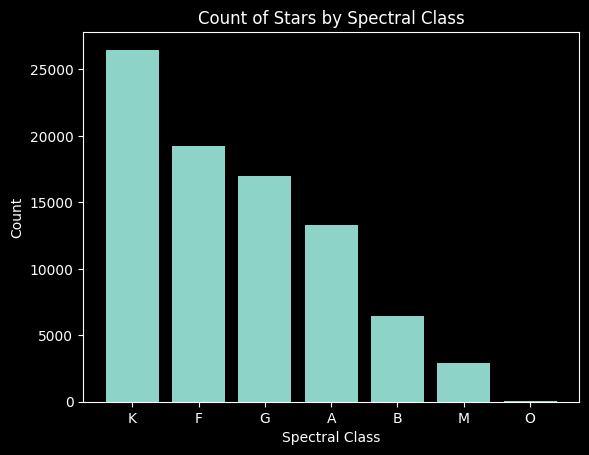

In [14]:
# plot the count of each spectral class
plt.bar(df['SpCl'].value_counts().index, df['SpCl'].value_counts())
plt.xlabel('Spectral Class')
plt.ylabel('Count')
plt.title('Count of Stars by Spectral Class')
plt.show()

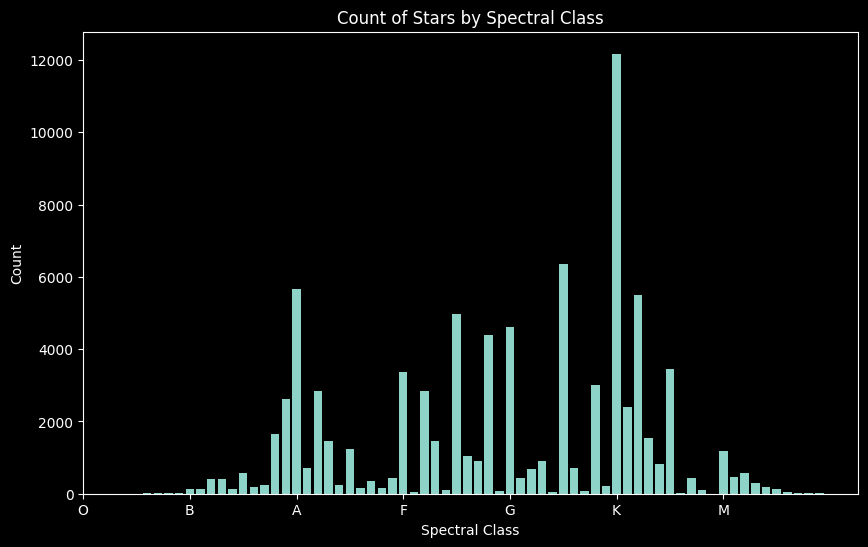

In [15]:
# plot the count of each spectral class Numerical
plt.figure(figsize=(10, 6))
plt.bar((df['SpClNum'] * 10).value_counts().index, (df['SpClNum'] * 10).value_counts())
plt.xlabel('Spectral Class')
plt.ylabel('Count')
plt.xticks([0, 10, 20, 30, 40, 50, 60], ['O', 'B', 'A', 'F', 'G', 'K', 'M'])
plt.title('Count of Stars by Spectral Class')
plt.show()

### Hertzsprung-Russell Diagram

In [16]:
# Filter to useable columns for H-R Diagram
df_HR = df.filter(items=['HIP', 'Vmag', 'Plx', 'B-V', 'SpType', 'Amag', 'Lum', 'Temp', 'SpCl', 'SpSubCl', 'LumCl'])

In [17]:
# filter out rows with missing or invalid temperature values
# filter out rows with temerpature less than 3000K or greater than 15000K
df_HR = df_HR[(df_HR['Temp'] >= 3000) & (df_HR['Temp'] <= 15000)]

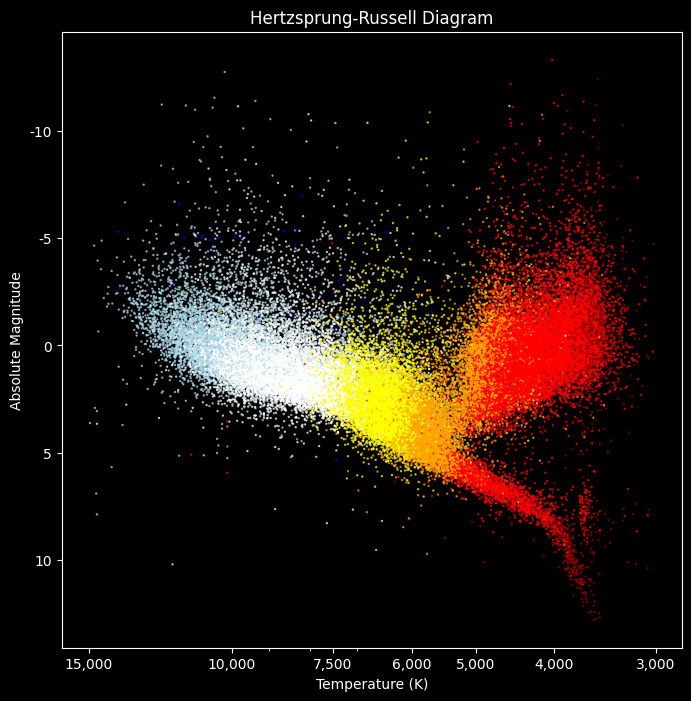

In [18]:
# Plotting the H-R Diagram
plt.figure(figsize=(8, 8))

# Set up the plots scales
plt.gca().invert_xaxis()  # Temperature decreases to the right
plt.gca().invert_yaxis()  # Absolute magnitude increases downwards
plt.xscale('log')
plt.yscale('linear')
plt.yticks([-10, -5, 0, 5, 10, 15], ['-10', '-5', '0', '5', '10', '15'])
plt.xticks([15000, 10000, 7500, 6000, 5000, 4000, 3000], ['15,000', '10,000', '7,500', '6,000', '5,000', '4,000', '3,000'])

# color each spectral class differently
spectral_classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
spectral_colors = ['blue', 'lightblue', 'white', 'yellow', 'orange', 'red', 'darkred']
colors = dict(zip(spectral_classes, spectral_colors))
color_series = df_HR['SpCl'].map(colors)

plt.scatter(df_HR['Temp'], df_HR['Amag'], c=color_series, s=0.5, alpha=0.7)

# Add labels and title
plt.xlabel('Temperature (K)')
plt.ylabel('Absolute Magnitude')
plt.title('Hertzsprung-Russell Diagram')
plt.show()

### Training Model

In [19]:
# Importing additional dependencies for machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [20]:
df_ML = df.drop(columns=['HIP', 'r_Vmag', 'r_B-V', 'r_V-I', 'SpType', 'r_SpType', 'Amag', 'Lum', 'Temp', 'SpSubCl', 'LumCl'])
df_ML.count()

Vmag        85424
Plx         85424
e_Plx       85424
BTmag       84521
e_BTmag     84521
VTmag       84551
e_VTmag     84551
B-V         85424
e_B-V       85424
V-I         85424
e_V-I       85424
Hpmag       85424
e_Hpmag     85424
Hpscat      85424
o_Hpmag     85424
Hpmax       85424
HPmin       85424
(V-I)red    85424
SpCl        85424
SpClNum     85424
dtype: int64

In [21]:
df_ML.head()

,Vmag,Plx,e_Plx,BTmag,e_BTmag,VTmag,e_VTmag,B-V,e_B-V,V-I,e_V-I,Hpmag,e_Hpmag,Hpscat,o_Hpmag,Hpmax,HPmin,(V-I)red,SpCl,SpClNum
0,9.10,3.54,1.39,9.643,0.020,9.130,0.019,0.482,0.025,0.55,0.03,9.2043,0.0020,0.017,87.0,9.17,9.24,0.66,F,3.5
2,6.61,2.81,0.63,6.576,0.004,6.621,0.005,-0.019,0.004,0.00,0.00,6.6081,0.0007,0.008,127.0,6.60,6.62,0.00,B,1.9
3,8.06,7.75,0.97,8.471,0.007,8.092,0.007,0.370,0.009,0.43,0.01,8.1498,0.0011,0.015,201.0,8.12,8.18,0.43,F,3.0
4,8.55,2.87,1.11,9.693,0.014,8.656,0.010,0.902,0.013,0.90,0.01,8.7077,0.0018,0.019,161.0,8.68,8.74,0.95,G,4.8
6,9.64,17.74,1.30,10.542,0.039,9.679,0.030,0.740,0.020,0.79,0.02,9.6795,0.0021,0.017,104.0,9.65,9.72,0.79,G,4.0


In [22]:
# Normalize?

#### Random Forest Regression for Spectral Class (including Subclass)

In [23]:
# Splitting data into features and target variable
X = df_ML.iloc[:, :-2]
y = df_ML.iloc[:, -1]

In [24]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 
rfr = RandomForestRegressor(
    criterion='poisson',
    max_depth=14,
    min_samples_leaf=4,
    n_estimators=73
)

In [71]:
rfr.fit(X_train, y_train)

,n_estimators,400
,criterion,'squared_error'
,max_depth,20
,min_samples_split,8
,min_samples_leaf,8
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
y_pred = rfr.predict(X_test)

In [ ]:
#rfr = RandomForestRegressor(criterion='poisson', max_depth=14, min_samples_leaf=4, n_estimators=73)
# 0.9523029135156618
rfr.score(X_test, y_test)

0.9523029135156618

In [50]:
print(pd.Series(rfr.feature_importances_, index=X.columns))

Vmag        0.000537
Plx         0.011617
e_Plx       0.002628
BTmag       0.002336
e_BTmag     0.001293
VTmag       0.001215
e_VTmag     0.001201
B-V         0.025063
e_B-V       0.002616
V-I         0.047059
e_V-I       0.000729
Hpmag       0.000654
e_Hpmag     0.001604
Hpscat      0.001598
o_Hpmag     0.002474
Hpmax       0.000566
HPmin       0.000561
(V-I)red    0.896250
dtype: float64


#### Random Forest Regression Hyperparameter Tuning

##### Random Forest Hyperparameters

In [65]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=400, num=10)]
# Criterion for splitting
criterion = ['squared_error', 'absolute_error', 'poisson']
# Maximum depth of the tree
max_depth = [10, 14, 20, 24, 30]
# Minimum number of samples required to split an internal node
min_samples_split = [2, 4, 6, 8]
# Minimum number of samples required to be at a leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Whether bootstrap samples are used when building trees
# bootstrap = True

In [66]:
# Creating the parameter grid
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'criterion': criterion,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    # 'bootstrap': bootstrap
}
print(param_grid)

{'n_estimators': [20, 62, 104, 146, 188, 231, 273, 315, 357, 400], 'max_depth': [10, 14, 20, 24, 30], 'criterion': ['squared_error', 'absolute_error', 'poisson'], 'min_samples_split': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 4, 6, 8]}


In [ ]:
rf_model = RandomForestRegressor()

In [68]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10, cv=3, verbose=2, random_state=101, n_jobs=4)


In [ ]:
rf_random.fit(X_train, y_train)